# Experiment 4A (Chapter 4)

This notebook covers the code to generate Figure 4.13 and 4.14 in Chapter 4 of the textbook "Fundamentals of Active Inference".

==========================================================================
* **Author**: Sanjeev Namjoshi (sanjeev.namjoshi@gmail.com)

* **Version**: 0.1

*This Jupyter notebook should only be distributed to members of the "Fundamentals of Active Inference" reading group hosted by the Active Inference Institute.*

Package versions:
* matplotlib==3.5.3
* numpy==1.21.5
* pyro-ppl==1.8.4
* pytorch==1.13.1

**Note**: All update rules in this notebook taken from [1]. Code heavily inspired by the Matlab script in the supplemental material of this paper.

[1] D. Oswtald, E. Kirilina, L. Starke, and F. Blankenburg. A tutorial on variational bayes for latent linear stochastic time-series models. Journal of Mathematical Psychology 60:1–19, 2014.

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import torch

from pyro.distributions import Normal, Gamma, MultivariateNormal
from scipy.special import psi, gamma

plt.rcParams.update({
    "figure.dpi": 120})

mpl.style.use("seaborn-deep")

## Free-form variational inference to find an unknown mean and precision

In this problem we attempt to learn the mean and precision (inverse variance) of a normal distribution from the data alone. The generative process is

$$
\mathscr{E} = \begin{cases}
    y_i \sim \mathcal{N}(y_i; \mu, \lambda) & \text{Data generation}
\end{cases}
$$

This just means that the data is generated from a Gaussian with mean $\mu$ and precision $\lambda$. We set the true values to
* $\mu^* = -1$
* $\lambda^* = 4$

and then generate $y$. First we create ranges for the variables and some simulation parameters/useful variables.

In [2]:
# Set data ranges
y_range       = torch.linspace(-4, 4, 100)
mu_range      = torch.linspace(-2, 2, 100)
lambda_range  = torch.linspace(7, 0.001, 100)

# Simulation details
iterations    = 8
mu_grid       = len(mu_range)
lambda_grid   = len(lambda_range)

Create the data.

In [3]:
""" Environment """
mu_true     = torch.tensor(-1.)
lambda_true = torch.tensor(4.)
y_true      = torch.exp(Normal(loc=mu_true, scale=torch.sqrt(1/lambda_true)).log_prob(y_range))

# Sample from environment to generate data
n           = 10
y           = torch.zeros(n)

torch.manual_seed(33254)
for i in range(n):
    y[i]    = mu_true + torch.sqrt(1. / lambda_true) * Normal(loc=0, scale=1).sample()

We pick the agent's generative model to be 

$$
\mathcal{M} = \begin{cases}
    p(y \mid \mu_y, \lambda_y) = \mathcal{N}(y_i; \mu_y, \lambda_y) & \text{Belief about observations} \\
    p_{m_\mu, s^2_\mu}(\mu_y) = \mathcal{N}(\mu_y; m_\mu, s^2_\mu) & \text{Prior on} \; \mu_y \\
    p_{ a_\lambda, b_\lambda}(\lambda_y) = \mathcal{G}(\lambda_y; a_\lambda, b_\lambda) & \text{Prior on} \; \lambda_y
\end{cases} 
$$

This means that the joint distribution factorizes such that the priors are independent. According to the model, the unknown (random) variables are $\mu_y$ and $\lambda_y$. We put these into a set for reference later: $\vartheta = \left \{\mu_y, \lambda_y \right \}$. Now we can say the desired posterior is $p(\vartheta \mid y)$. Which is approximated by the variational density $q(\vartheta)$.

We choose to factorize $q$ under the mean-field approximation as: $q(\vartheta) = \prod_i q(\vartheta_i) = q(\mu_y) q(\lambda_y)$. Assigning normal distributions to each partition we get

$$
\begin{aligned}
    q(\mu_y) &= \mathcal{N}(\mu_y; m^q_\mu, {s^2_\mu}^q) \\
    q(\lambda_y) &= \mathcal{G}(\lambda_y; a^q_\lambda, b^q_\lambda)
\end{aligned}
$$

Now we can pick initial values for the prior parameters:
* $m_\mu$ = 0
* $s_\mu$ = 1
* $a_\lambda$ = 1
* $b_\lambda$ = 1

And we assign these to be the initializations of the parameters of $q$:
* ${m^q_\mu}^{(0)} = {m_\mu}^{(0)}$
* ${{s^2_\mu}^q}^{(0)} = {s_\mu}^{(0)}$
* ${a^q_\lambda}^{(0)} = {a_\lambda}^{(0)}$
* ${b^q_\lambda}^{(0)} = {b_\lambda}^{(0)}$


In [4]:
""" Agent """
# Prior parameter initializations
m_mu_prior      = 0   # Mean of p(mu)
s_mu_prior      = 1   # Variance of p(mu)
a_lambda_prior  = 1   # Rate of p(lambda)
b_lambda_prior  = 1   # Scale of p(lambda)

# Initialize empty arrays to be filled
m_mu            = torch.zeros(iterations + 1)
s_mu            = torch.zeros(iterations + 1)
a_lambda        = torch.zeros(iterations + 1)
b_lambda        = torch.zeros(iterations + 1)
vfe             = torch.zeros(iterations + 1)
q               = torch.zeros(mu_grid, lambda_grid, iterations + 1)
exp_y_qmul      = torch.zeros(iterations + 1, mu_grid)
kld             = torch.zeros(iterations + 1)

# Initialize variational distribution parameters with priors.
m_mu[0]         = m_mu_prior       # Mean of q(mu)
s_mu[0]         = s_mu_prior       # Variance of q(mu)
a_lambda[0]     = a_lambda_prior   # Rate of q(lambda)
b_lambda[0]     = b_lambda_prior   # Scale of q(lambda)

Under the initializations set above we can determine the current best guess for $q(\mu_y)$ and $q(\lambda_y)$. Taking the outer product with `torch.outer()` allows us to obtain the initial guess for $q(\mu_y, \lambda_y) = q(\mu_y) \times q(\lambda_y)$.

In [5]:
# Initialize factorized q
q_mu        = torch.exp(Normal(loc=m_mu[0], scale=torch.sqrt(s_mu[0])).log_prob(mu_range))
q_lambda    = torch.exp(Gamma(concentration=a_lambda[0], rate=1/b_lambda[0]).log_prob(lambda_range))
q[:, :, 0]  = torch.outer(q_mu, q_lambda)

We also need to compute our current best guess for $p(y)$ with the current variational density $q(\mu_y, \lambda_y)$. To do this we simply take the mean of each factorized distribution. For $q(\mu_y)$ this is just the mean $m^q_\mu$ since this distribution is normal. For $q(\lambda_y)$ which is a gamma distribution, we can obtain the mean by multiplying the shape and rate parameters, $a^q_\lambda b^q_\lambda$. We then set these to the mean and standard deviation of a normal to get our initial guess for $p(y)$.

**Note**: $\lambda_y$ must be inverted to obtain variance. Then we take the square root because the `torch` normal distribution function takes standard deviation.

In [6]:
# Marginal expectations
exp_mu_qmu          = m_mu[0]
exp_lambda_qlambda  = a_lambda[0] * b_lambda[0]
exp_y_qmul[:, :]    = torch.exp(Normal(loc=exp_mu_qmu, scale=torch.sqrt(1/exp_lambda_qlambda)).log_prob(y_range))

We now need functions to compute VFE and KL divergence. In the book we show that the function for VFE is composed of three separate terms. The first term (t1)

$$
D_{KL}(q^{(j)}(\mu_y) \parallel p(\mu_y)) = \frac{1}{2} \log \frac{s^2_\mu}{{{s^2_\mu}^q}^{(j)}} + \frac{m_\mu^2 + {{m_\mu^{q}}^{(j)}}^2 + {{s^2_\mu}^q}^{(j)} - 2{m_\mu^{q}}^{(j)} m_\mu}{2 s^2_\mu} - \frac{1}{2}
$$

The second term (t2) is 

$$
\begin{split}
    D_{KL}(q^{(j)}(\lambda_y) \parallel p(\lambda_y)) &= \left ({b^q_\lambda}^{(j)} -1 \right ) \psi \left ({b^q_\lambda}^{(j)} \right ) - \log {a^q_\lambda}^{(j)} - {b^q_\lambda}^{(j)} - \log \Gamma \left ({b^q_\lambda}^{(j)} \right ) \\
    &\qquad + \log \Gamma(b_\lambda) + b_\lambda \log a_\lambda - (b_\lambda -1) \left (\psi \left ({b^q_\lambda}^{(j)} \right ) + \log {a^q_\lambda}^{(j)} \right ) + \frac{{a^q_\lambda}^{(j)}{b^q_\lambda}^{(j)}}{a_\lambda}
\end{split} \\
$$

The third term (t3) is

$$
\begin{split}
    \int q^{(i)}(\mu_y) q^{(j)}(\lambda_y) \log p(y \mid \vartheta) d\vartheta &= \frac{1}{2} \left (\psi \left ({a^q_\lambda}^{(j)} \right ) + \log \left ({b^q_\lambda}^{(j)} \right ) \right ) \\
    &\qquad - \frac{1}{2} {a^q_\lambda}^{(j)} {b^q_\lambda}^{(j)} \left (\sum_{i=1}^n y^2_i + n \left ( \left ({m_\mu^{q}}^{(j)} \right )^2 + {{s^2_\mu}^q}^{(j)} \right ) - 2{m_\mu^{q}}^{(j)} \sum_{i=1}^n y_i \right )
\end{split}
$$

Then we combine them to get: `VFE = t1 - t2 + t3`. The KL-divergence function is explained in the notebook `4__kl_divergence.ipynb`.

In [3]:
# VFE evaluation
def calc_vfe(
    n: int, 
    y_bar: float, 
    yy_bar: float, 
    m_mu: float, 
    s_mu: float, 
    m_mu_prior: float, 
    s_mu_prior: float, 
    a_lambda: float, 
    b_lambda: float, 
    a_lambda_prior: float, 
    b_lambda_prior: float, 
    iteration: int) -> float:
    
    """ Calculate variational free energy
    
    n              [int]   : Number of samples
    y_bar          [float] : Data mean
    yy_bar         [float] : Data variance
    m_mu           [float] : Mean of q(mu) at iteration (j)
    s_mu           [float] : Variance of q(mu) at iteration (j)
    m_mu_prior     [float] : Initial mean of q(mu) at iteration (j=0)
    s_mu_prior     [float] : Initial variance of q(mu) at iteration (j=0)
    a_lambda       [float] : Scale of q(lambda) at iteration (j)
    b_lambda       [float] : Rate of q(lambda) at iteration (j)
    a_lambda_prior [float] : Initial scale of q(lamba) at iteration (j=0)
    b_lambda_prior [float] : Initial rate of q(lambda) at iteration (j=0)
    iteration      [int]   : Iteration (j) over which to calculate VFE

    Returns:
        float: Variational free energy at iteration (j)
    """
    
    # Term 1
    l_av         = 0.5 * (psi(a_lambda) + torch.log(b_lambda)) - (0.5 * a_lambda * b_lambda * (yy_bar + n * (m_mu**2 + s_mu)) - (2 * m_mu * y_bar)) 
    
    # Term 2
    kl_q_mu      = 0.5 * torch.log(s_mu_prior / s_mu) + ((m_mu_prior**2 + m_mu**2 + s_mu - 2 * m_mu * m_mu_prior) / (2 * s_mu)) - 0.5
    
    # Term 3
    kl_q_lambda  = (b_lambda - 1) * psi(b_lambda) - torch.log(a_lambda) - b_lambda - torch.log(gamma(b_lambda)) + torch.log(gamma(b_lambda_prior)) + b_lambda_prior * torch.log(a_lambda) - (b_lambda - 1) * (psi(b_lambda) + torch.log(a_lambda)) + ((a_lambda * b_lambda) / a_lambda_prior) 
    
    # Combine
    return (l_av - (kl_q_mu + kl_q_lambda))

def kl_divergence(p_a: torch.tensor, p_b: torch.tensor, stable=True):
    
    # Stabilize zero values so they don't go to inf when taking log
    if stable:
        eps = 1e-8
        p_a[p_a == 0] = eps
        p_b[p_b == 0] = eps
    
    # Compute KL divergence
    return torch.sum(p_a * (torch.log(p_a) - torch.log(p_b)))

Lastly, we compute the initial VFE and KLD. We also calculate some data statistics that are useful in some equations to reduce clutter.

In [8]:
# Data stats
y_bar   = torch.sum(y)
yy_bar  = torch.sum(y**2)

# Calculate VFE and KLD at initialization
vfe[0]  = calc_vfe(n, y_bar, yy_bar, m_mu[0], s_mu[0], m_mu[0], s_mu[0], a_lambda[0], b_lambda[0], a_lambda[0], b_lambda[0], 0)
kld[0]  = kl_divergence(y_true, exp_y_qmul[0, :])

Now we run the main loop of the free-form, mean-field VI algorithm. At each step we compute the update rules for the variational density parameters:

$$
\begin{aligned}
    {m_\mu^{q}}^{(j+1)} &= \frac{m_\mu + s^2_\mu {a_\lambda^q}^{(j)}{b_\lambda^q}^{(j)} \sum_{i=1}^n y_n}{1 + n \cdot s^2_\mu {a_\lambda^q}^{(j)}{b_\lambda^q}^{(j)}} \\
    {{s^2_\mu}^q}^{(j+1)} &= \frac{s^2_\mu}{1 + n \cdot s^2_\mu {a_\lambda^q}^{(j)}{b_\lambda^q}^{(j)}} \\
    {a^q_\lambda}^{(j+1)} &= \frac{n}{2} + a_\lambda \\
    {b^q_\lambda}^{(j+1)} &= \left (\frac{1}{b_\lambda} + \frac{1}{2} \left (\sum_{n=1}^n y^2_n - 2 \sum_{n=1}^n y_n {m_\mu^{q}}^{(j+1)} + n \left (\left ({m_\mu^{q}}^{(j+1)} \right )^2 +  {{s^2_\mu}^q}^{(j+1)} \right ) \right ) \right )^{-1}
\end{aligned}
$$

Then we update our new guess for $q(\vartheta)$ and $p(y)$ along with VFE and KL-divergence. These updates are identical to how we performed them at initialization.

In [9]:
""" Simulation """
for j in range(iterations):
    
    # Update mean and variance of q(mu)
    m_mu[j+1]           = (m_mu_prior + (s_mu_prior * a_lambda[j] * b_lambda[j] * y_bar)) / (1 + (n * s_mu_prior * a_lambda[j] * b_lambda[j]))
    s_mu[j+1]           = s_mu_prior / (1 + (n * s_mu_prior * a_lambda[j] * b_lambda[j]))
    
    # Update q(vartheta) = q(mu)q(lambda)
    q_mu                = torch.exp(Normal(loc=m_mu[j+1], scale=torch.sqrt(s_mu[j+1])).log_prob(mu_range))
    q_lambda            = torch.exp(Gamma(concentration=a_lambda[j], rate=1/b_lambda[j]).log_prob(lambda_range))
    q[:, :, j+1]        = torch.outer(q_mu, q_lambda)

    # Update expectations of p(y) = N(y; mu, lambda)
    exp_mu_qmu          = m_mu[j+1]
    exp_lambda_qlambda  = a_lambda[j] * b_lambda[j]
    exp_y_qmul[j+1]     = torch.exp(Normal(loc=exp_mu_qmu, scale=torch.sqrt(1/exp_lambda_qlambda)).log_prob(y_range))
    
    # Update rate and scale of q(lambda)
    a_lambda[j+1]       = (n / 2) + a_lambda_prior
    b_lambda[j+1]       = 1 / (1 / b_lambda_prior + ((1/2) * (yy_bar - (2 * m_mu[j+1] * y_bar) + (n * (m_mu[j+1]**2 + s_mu[j+1])))))
    
    # Update q(vartheta) = q(mu)q(lambda)
    q_mu                = torch.exp(Normal(loc=m_mu[j+1], scale=torch.sqrt(s_mu[j+1])).log_prob(mu_range))
    q_lambda            = torch.exp(Gamma(concentration=a_lambda[j+1], rate=1/b_lambda[j+1]).log_prob(lambda_range))
    q[:, :, j+1]        = torch.outer(q_mu, q_lambda)

    # Update expectations of p(y) = N(y; mu, lambda)
    exp_mu_qmu          = m_mu[j+1]
    exp_lambda_qlambda  = a_lambda[j+1] * b_lambda[j+1]
    exp_y_qmul[j+1]     = torch.exp(Normal(loc=exp_mu_qmu, scale=torch.sqrt(1/exp_lambda_qlambda)).log_prob(y_range))
    
    # Update VFE and KLD
    vfe[j+1]            = calc_vfe(n, y_bar, yy_bar, m_mu[j+1], s_mu[j+1], m_mu[0], s_mu[0], a_lambda[j+1], b_lambda[j+1], a_lambda[0], b_lambda[0], j+1)
    kld[j+1]            = kl_divergence(y_true, exp_y_qmul[j+1, :])

And finally we plot the results.

<Figure size 720x480 with 0 Axes>

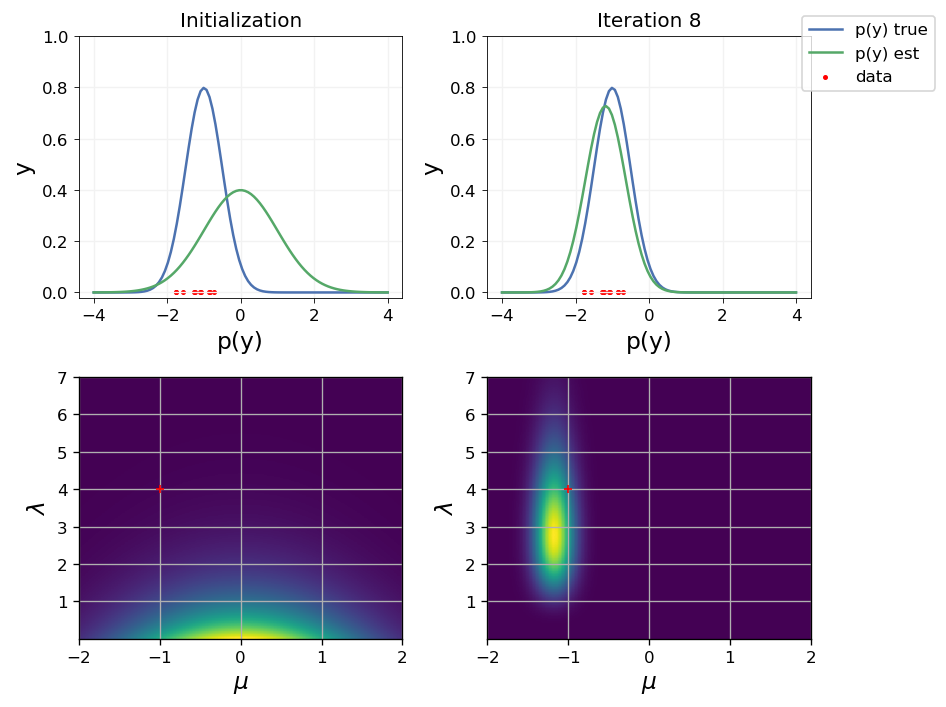

In [10]:
fig = plt.figure()
fig, axes = plt.subplots(2, 2, facecolor=(1,1,1), figsize=(7,6))

iters = [0, 8]
cols = [0, 1]

mu_min = min(mu_range)
mu_max = max(mu_range)
lambda_min = min(lambda_range)
lambda_max = max(lambda_range)

axes[0,0].plot(y_range, y_true)
axes[0,0].plot(y_range, exp_y_qmul[0, :])
axes[0,0].scatter(y, torch.zeros(n), s=4, c="red")
axes[0,0].set_ylim(-0.02, 1)

axes[0,1].plot(y_range, y_true, label="p(y) true")
axes[0,1].plot(y_range, exp_y_qmul[8, :], label="p(y) est")
axes[0,1].scatter(y, torch.zeros(n), s=4, c="red", label="data")
axes[0,1].set_ylim(-0.02, 1)

axes[1,0].imshow(q[:, :, 0].T, origin="upper", cmap="viridis", extent=[mu_min,mu_max,lambda_min,lambda_max], aspect="auto")
axes[1,0].plot(mu_true, lambda_true, marker="+", color="red", markersize=5)
axes[1,0].grid()
axes[1,1].imshow(q[:, :, 8].T, origin="upper", cmap="viridis", extent=[mu_min,mu_max,lambda_min,lambda_max], aspect="auto") 
axes[1,1].plot(mu_true, lambda_true, marker="+", color="red", markersize=5)
axes[1,1].grid()

# Axis labels
axes[0,0].set_xlabel("p(y)", fontsize=14)
axes[0,0].set_ylabel("y", fontsize=14)
axes[0,1].set_xlabel("p(y)", fontsize=14)
axes[0,1].set_ylabel("y", fontsize=14)
axes[1,0].set_xlabel("$\mu$", fontsize=14)
axes[1,0].set_ylabel("$\lambda$", fontsize=14)
axes[1,1].set_xlabel("$\mu$", fontsize=14)
axes[1,1].set_ylabel("$\lambda$", fontsize=14)

# Column titles
axes[0,0].set_title("Initialization")
axes[0,1].set_title("Iteration 8")


# Cosmetic changes and axes ranges
for ax in axes[:1].reshape(-1):
    ax.axes.grid(which="major", axis="both", c="#f2f2f2")
    plt.setp(ax.spines.values(), color="black", linewidth=0.5)
    ax.tick_params(
        axis='both',          
        which='major',      
        bottom=True,
        left=True,
        color="black",
        width=0.5,
        length=3)
    
fig.legend(loc="upper right", bbox_to_anchor=(1.13, 0.98), frameon=True)
fig.tight_layout()

We can also plot KLD, VFE, and surprisal.

<Figure size 720x480 with 0 Axes>

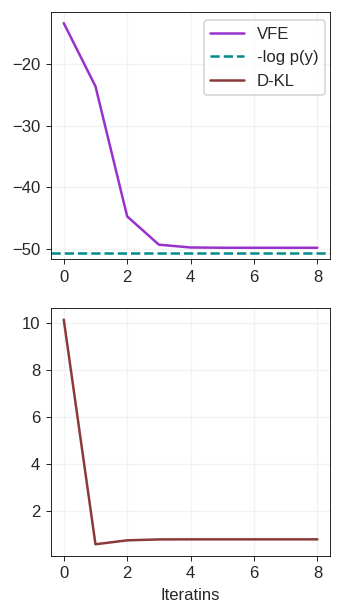

In [11]:
plt.style.use("seaborn-whitegrid")
fig = plt.figure()
fig, axes = plt.subplots(2, 1, facecolor=(1,1,1), figsize=(3,6))

axes[0].plot(range(iterations+1), vfe, c="#9932CC", label="VFE")
axes[0].axhline((vfe-kld)[-1], 0, c="#008B8B", label="-log p(y)", ls="--")
axes[1].plot(range(iterations+1), kld, c="#8B3A3A", label="D-KL")

axes[1].set_xlabel("Iteratins")

for ax in axes:
    ax.axes.grid(which="major", axis="both", c="#f2f2f2")
    plt.setp(ax.spines.values(), color="black", linewidth=0.5)
    ax.tick_params(
        axis='both',          
        which='major',      
        bottom=True,
        left=True,
        color="black",
        width=0.5,
        length=3)
    
fig.legend(loc="upper right", bbox_to_anchor=(0.91, 0.88), frameon=True)